In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [3]:
weather_data = np.load('./data/weatherdata.npy')
music_data = np.load('./data/musicdata.npy')
bookreasturant_data = np.load('./data/bookreasturantdata.npy')

In [4]:
print(weather_data.shape)
print(music_data.shape)
print(bookreasturant_data.shape)
data = np.concatenate((weather_data, music_data), axis=0)
data = np.concatenate((data, bookreasturant_data), axis=0)
np.random.shuffle(data)

(2400, 2)
(2400, 2)
(1973, 2)


In [5]:
df = pd.DataFrame()
df = pd.DataFrame(data)
df = df.dropna()
df = df.reset_index(drop=True)
df[0].astype(str).values
df[1].astype(str).values
df.columns = ['message', 'class']
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['class'])))

('Shape of dataset ', (6773, 2))
Index([u'message', u'class'], dtype='object')
('No. of unique classes', 3)


In [6]:
print(df)

                                                message           class
0     me and aisha and craving cordon bleu and need ...  bookrestaurant
1     Is it forecast to be stormy close to Nimule-Na...         weather
2                              play some latin on Zvooq           music
3     Please play the newest music by Evil Jared Has...           music
4                     Play something by Louisiana Blues           music
5           Play Igor Nikolayev music from the fourties           music
6     Will it be snowy on february the 14th, 2021 in...         weather
7     Tell me the weather forecast for Sugarloaf Pro...         weather
8               Play the top-ten soundtrack from Kiara.           music
9     what is the forecast starting at six pm at Jan...         weather
10               Lets eat at Newport Creamery in Carnot  bookrestaurant
11                          book a best tavern for nine  bookrestaurant
12                Play rie fu music sorted by the best.         

In [7]:
macronum=sorted(set(df['class']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['class']=df['class'].apply(fun)

In [8]:
texts = []
labels = []

import spacy
import time
nlp = spacy.load('en_core_web_sm')

for idx in range(df.message.shape[0]):
    text = df.message[idx]
    doc = nlp(text)
    wordsinsidetext = ""
    newtext = 1
    for token in doc:
        if not token.is_stop:
            if newtext == 1:
                wordsinsidetext = wordsinsidetext + (str(token.lemma_))
            if newtext == 0:
                wordsinsidetext = wordsinsidetext + " " + (str(token.lemma_))
            newtext = 0
    texts.append(wordsinsidetext.encode())


# for idx in range(df.message.shape[0]):
#     text = BeautifulSoup(df.message[idx])
#     texts.append(clean_str(str(text.get_text().encode())))

for idx in df['class']:
    labels.append(idx)

    
print(len(texts))

import pickle
with open('textsdata', 'wb') as fp:
    pickle.dump(texts, fp)

6773


In [9]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
# print(sequences)
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

('Number of Unique Tokens', 6552)


In [10]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(data)
labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
# print(x_train[0])

[[   0    0    0 ...    2   10   53]
 [   0    0    0 ...  223   23   49]
 [   0    0    0 ...    1  510   87]
 ...
 [   0    0    0 ...   42  148 1385]
 [   0    0    0 ... 2331 6551  390]
 [   0    0    0 ...  290 6552  191]]
('Shape of Data Tensor:', (6773, 1000))
('Shape of Label Tensor:', (6773, 3))


In [11]:
embeddings_index = {}
# f = open('glove.6B.100d.txt',encoding='utf8')
import io
f = io.open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [12]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [13]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         655300    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 816,703
Trainable params: 816,703
Non-trainable params: 0
_________________________________________________________________


In [14]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Train on 5419 samples, validate on 1354 samples
Epoch 1/15
5419/5419 [==============================] - 7624s 1s/step - loss: 0.0705 - acc: 0.9825 - val_loss: 0.0468 - val_acc: 0.9934

Epoch 00001: val_acc improved from -inf to 0.99335, saving model to model_rnn.hdf5
Epoch 2/15
5419/5419 [==============================] - 5021s 927ms/step - loss: 0.0320 - acc: 0.9965 - val_loss: 0.0792 - val_acc: 0.9897

Epoch 00002: val_acc did not improve from 0.99335
Epoch 3/15
5419/5419 [==============================] - 5238s 967ms/step - loss: 0.0300 - acc: 0.9967 - val_loss: 0.0836 - val_acc: 0.9911

Epoch 00003: val_acc did not improve from 0.99335
Epoch 4/15
5419/5419 [==============================] - 4549s 839ms/step - loss: 0.0247 - acc: 0.9978 - val_loss: 0.0809 - val_acc: 0.9911

Epoch 00004: val_acc did not improve from 0.99335
Epoch 5/15
5419/5419 [==============================] - 4774s 881ms/step - loss: 0.0216 - acc: 0.9982 - val_loss: 0.0427 - val_acc: 0.9948

Epoch 00005: val_acc i

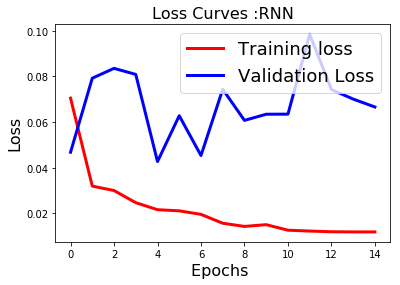

In [15]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

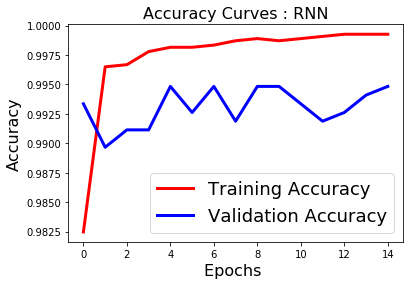

In [16]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

In [17]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [20]:
model.predict(x_train[0:1])

array([[1.0000000e+00, 3.6387536e-15, 5.1624012e-14]], dtype=float32)